# additional

In [ ]:
import pandas as pd

In [ ]:
declarations = pd.read_csv('new_data/all_declarations_pmd.csv')

In [ ]:
population_grouped = population.groupby('oblast')['population'].sum().reset_index(name='population_count')

In [ ]:
decl_grouped = declarations.groupby('division_area')['count_declarations'].sum().reset_index(name='decl_count')

In [ ]:
decl_grouped['population'] = population_grouped.population_count

In [ ]:
population_grouped['area'] = decl_grouped.division_area

In [ ]:
decl_grouped.division_area = decl_grouped.division_area.str.title()
decl_grouped.division_area = decl_grouped.division_area.str.replace('М.Київ', 'Київ')

In [ ]:
merged = pd.merge(decl_grouped,population_grouped, left_on='division_area', right_on='oblast')

In [ ]:
merged['ratio'] = merged.decl_count / merged.population_count * 100

In [ ]:
merged[['division_area', 'ratio']].to_csv('oblast_data.csv')

# data for project

In [1]:
import pandas as pd

In [2]:
declarations = pd.read_csv('new_data/all_declarations_pmd.csv', dtype={'division_settlement_koatuu': 'str', 
                                                                     'legal_entity_edrpou': 'str'})
pmd = pd.read_csv('new_data/pmd_all_contracted_legal_entities.csv', dtype={'legal_entity_edrpou': 'str'}) 

/home/ptrbdr/git/medical_reform/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
declarations.columns

Index(['date_upd', 'division_area', 'division_region', 'division_settlement',
       'division_settlement_type', 'division_settlement_koatuu',
       'legal_entity_is_contract', 'legal_entity_id', 'legal_entity_edrpou',
       'legal_entity_name', 'division_id', 'employee_speciality',
       'party_gender', 'party_name', 'person_gender', 'person_age',
       'count_declarations'],
      dtype='object')

In [6]:
t = declarations.groupby(['party_name', 'legal_entity_id'])['count_declarations'].sum().reset_index(name='decl_sum')

In [9]:
small = len(t[t.decl_sum > 2000])
large = len(t[t.decl_sum < 1000])

In [12]:
small,large,len(t)

(1859, 9122, 22919)

In [34]:
hospitals_edrpou = pd.read_csv('old_data/hospitals_grouped_by_regions.csv', dtype={'le_transfer': 'str'})

In [35]:
population = pd.read_csv('old_data/population.csv')

In [ ]:
declarations_grouped = declarations.groupby(['legal_entity_id'],
                                            as_index=False)['count_declarations'].sum()

In [ ]:
decl_for_stats = declarations.groupby(['legal_entity_id', 'party_name'],as_index=False)['count_declarations'].sum()

In [ ]:
decl_for_stats.sort_values('count_declarations', ascending=False)

In [ ]:
declarations[declarations.party_name.str.contains("Верховець")].groupby('person_age')['count_declarations'].sum()

## horizontal bar chart

цю хуйню треба виправити, випадає дуже багато лікарень (десь 600) і через це по багатьох районах нестача. 

In [ ]:
merged_hospitals = pd.merge(pmd, hospitals_edrpou, left_on="legal_entity_edrpou", right_on="le_transfer", how="left")
merged_hospitals = merged_hospitals[~merged_hospitals.name.isnull()]

In [ ]:
merged_hospitals_population = pd.merge(merged_hospitals,
                                       population, left_on=['name', 'oblast_name'],
                                       right_on=['rajon_grouped', 'oblast'], how='left')

merged_hospitals_population = merged_hospitals_population[~merged_hospitals_population.division_region.isnull()]

In [ ]:
hospitals_population_declarations = pd.merge(merged_hospitals_population,
                                             declarations_grouped, on='legal_entity_id', how='left')

hospitals_population_declarations = hospitals_population_declarations[~hospitals_population_declarations.count_declarations.isnull()]

In [ ]:
hospitals_population_declarations['decl_ratio'] = pd.Series(hospitals_population_declarations.count_declarations / hospitals_population_declarations.population)

In [ ]:
hospitals_population_declarations[hospitals_population_declarations.decl_ratio < 0.5]

# data for table 

по суті він не оновлений, тут старі дані, але поки нехай буде, щоб не зайобуватися

In [19]:
prozorro = pd.read_json('old_data/data_short_line.json', dtype={'hospital_edrpou': 'str'})
# prozorro['id_item_short'] = 'type:' + prozorro.id_item.str[:3]
prozorro['id_item_short'] = ["type:"+a[:2]if a[:2] != '33' else "type:"+a[:3] for a in prozorro.id_item]
prozorro.date = pd.to_datetime(prozorro.date, utc=True)
prozorro['date'] = prozorro.date.dt.tz_localize(None)
prozorro = prozorro[~prozorro.date.isnull()]
prozorro['date_month'] = pd.to_datetime(prozorro.date.map(lambda x: str(x.year) + "-" + str(x.month)), format="%Y-%m")

prozorro = pd.merge(prozorro, prozorro.groupby('hospital_name', as_index=False)['sum'].size()\
         .to_frame('number_of_tenders'), how='left', on='hospital_name')
prozorro = prozorro.loc[prozorro.hospital_edrpou != '05766356']


ValueError: Expected object or value

In [ ]:
top_100_per_category = prozorro.groupby('id_item_short').apply(lambda x: x.nlargest(100, 'sum')).reset_index(drop=True)
(top_100_per_category[['hospital_name', 'overal_title', 'id_item_short', 'sum']]
     .to_json('output/top_100_per_category.json', 'records', force_ascii=False))

In [ ]:
hospitals_grouped_by_regions = pd.read_csv('old_data/hospitals_grouped_by_regions.csv')


In [ ]:
table_data = pd.merge(top_100_per_category, hospitals_grouped_by_regions,
         left_on='hospital_edrpou', right_on='le_transfer',
         how='left'
        )

In [ ]:
output = (
    table_data[~table_data.oblast_name.isnull()]
         [[
           'hospital_name', 'overal_title',
           'hospital_edrpou','id_item_short',
           'oblast_name', 'sum'
         ]]
     )
output.loc[output.oblast_name.str.contains('м. Київ'), 'oblast_name'] = 'Київ'

output.to_json('output/top_100_per_category.json', 'records', force_ascii=False)

# data for slope charts

In [ ]:
# поки зачекає

# data for doctors table

In [ ]:
import pandas as pd
pmd = pd.read_csv('new_data/pmd_all_contracted_legal_entities.csv')

In [ ]:
declarations_hospital_address = pd.merge(declarations, pmd[[
                                                           'division_residence_addresses',
                                                           'legal_entity_id', 'division_id']],
on=['legal_entity_id', 'division_id'], how='left')

In [ ]:
declarations_hospital_address = declarations_hospital_address[~declarations_hospital_address.division_residence_addresses.isnull()]

In [ ]:
declarations_hospital_address['division_residence_addresses'] = (declarations_hospital_address.division_residence_addresses.str.split(', ').str[-2:].str.join(', '))



In [ ]:
declarations_hospital_address['division_residence_addresses'] = declarations_hospital_address.division_residence_addresses.str.title()
declarations_hospital_address['legal_entity_name'] = declarations_hospital_address.legal_entity_name.str.title()
declarations_hospital_address['division_area'] = declarations_hospital_address.division_area.str.title()
declarations_hospital_address.loc[declarations_hospital_address.division_area == 'М.Київ', 'division_area'] = 'Київ'
declarations_hospital_address['division_residence_addresses'] = declarations_hospital_address.division_residence_addresses.str.title()
declarations_hospital_address['division_residence_addresses'] = declarations_hospital_address.division_residence_addresses.str[0].str.lower() + declarations_hospital_address.division_residence_addresses.str[1:]
declarations_hospital_address['division_residence_addresses'] = declarations_hospital_address.division_residence_addresses.str.replace('Будинок', 'будинок')


In [ ]:
decl_count_total = declarations_hospital_address.groupby(['division_id', 'party_name'])['count_declarations']\
    .sum().reset_index(name='decl_count_total')

In [ ]:
declarations_hospital_address_total = pd.merge(declarations_hospital_address, decl_count_total,
                                               on=['division_id', 'party_name'], how='left')

In [ ]:
declarations_hospital_address_total_short = declarations_hospital_address_total[['party_name', 'legal_entity_name', 'decl_count_total',
                                    'division_settlement', 'legal_entity_edrpou', 'division_area', 'division_residence_addresses']]


# 'doctor_full_name', 'le_transfer', 'total_decl_count', 'division_settlement', 'da_area', 'division_address'

In [ ]:
declarations_hospital_address_total_short['division_settlement'] = declarations_hospital_address_total_short\
    .division_settlement.str.title()
declarations_hospital_address_total_short['division_area'] = declarations_hospital_address_total_short\
    .division_area.str.title()

In [ ]:
# 'doctor_full_name', 'le_transfer', 'total_decl_count', 'division_settlement', 'da_area', 'division_address'

In [ ]:
repl = lambda m: m.group(0).lower()
declarations_hospital_address_total_short['division_residence_addresses'] = (declarations_hospital_address_total_short.division_residence_addresses
                                                    .str.replace("((?<=').)", repl))

In [ ]:
to_replace = {"Кам'Янський": "Кам'янський", "Кам'Янка": "Кам'янка","Об'Єднаної": "Об'єднаної",
              "П'Ятий": "П'ятий", "Дем'Янівна": "Дем'янівна"}

In [ ]:
declarations_hospital_address_total_short['legal_entity_name'] = declarations_hospital_address_total_short.legal_entity_name.replace(to_replace, regex=True).replace("''", "").str.strip()

In [ ]:
declarations_hospital_address_total_short['legal_entity_name'] = (declarations_hospital_address_total_short
    .legal_entity_name.str.replace('Комунальне Некомерційне Підприємство', '')
    .str.replace("Комунальне Медичне Підприємство", "")
    .str.replace("Приватне Акціонерне Товариство", '')
    .str.replace("Центр Первинної Медичної Допомоги", '')
    .str.replace("Товариство З Обмеженою Відповідальністю", ""))


In [ ]:
declarations_hospital_address_total_short.legal_entity_name = declarations_hospital_address_total_short.legal_entity_name.str.replace("'Я", "'я")

In [ ]:
declarations_hospital_address_total_short = declarations_hospital_address_total_short.drop('legal_entity_name', axis=1)

In [ ]:
declarations_hospital_address_total_short.columns

In [ ]:
declarations_hospital_address_total_short.columns = ['doctor_full_name', 'total_decl_count',
                                                     'division_settlement','le_transfer', 'da_area', 'division_address',
                                                    ]
# 'doctor_full_name', 'le_transfer', 'total_decl_count', 'division_settlement', 'da_area', 'division_address'

In [ ]:
(declarations_hospital_address_total_short
    .to_json('output/doctors_for_table_new.json', force_ascii=False, orient='records'))


# Horizontal bar chart

In [ ]:
population_koatuu = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQbS_RGIXyICClVFJvy-TsxK4GT6CW8QXobMfT9FBopsab_ZYqHmwaXZmUFCHrRVBX5RezxepaPRhSs/pub?gid=1442300754&single=true&output=csv')

population_koatuu['short_koatuu'] = population_koatuu['id'].str.replace('T0*', "", regex=True).str[:5]
declarations['short_koatuu'] = declarations.division_settlement_koatuu.str[:5]

# declarations['short_koatuu'] = declarations.division_settlement_koatuu.str[:4]
# population_koatuu['short_koatuu'] = population_koatuu['id'].str[3:8]

merged_decl_population = pd.merge(declarations, population_koatuu[['short_koatuu', 'rajon_grouped', 'oblast', 'total_population']],
        on='short_koatuu', how='left')

merged_decl_population_without_null = merged_decl_population[~merged_decl_population.rajon_grouped.isnull()]

merged_decl_population_without_null['total_decl'] = merged_decl_population_without_null.groupby('short_koatuu').count_declarations.transform('sum')

merged_decl_population_without_null['declarations_ratio'] = (merged_decl_population_without_null.total_decl/merged_decl_population_without_null.total_population * 100)

output = merged_decl_population_without_null[merged_decl_population_without_null.ratio > 35].drop_duplicates(['rajon_grouped', 'oblast'])
output.loc[output.oblast == 'Київ', 'oblast'] = 'Київська'

output[['oblast', 'rajon_grouped', 'declarations_ratio']].to_json('output/rajon_stats_new.json', force_ascii=False, orient='records')


# Bar chart

In [3]:
declarations['decl_count'] = declarations.groupby(['party_name', 'division_id']).count_declarations.transform('sum')

In [4]:
tarifs = {'y0-5': 4, 'y6-17': 2.2, 'y18-39': 1, 'y40-64':1.2, 'y65+': 2}

In [5]:
declarations['money_per_month_not_grouped'] = declarations.apply(lambda x: tarifs[x['person_age']] * (370/12) * x['count_declarations'], axis=1)

In [6]:
declarations['money_per_month'] = declarations.groupby(['party_name', 'division_id']).money_per_month_not_grouped.transform('sum')

In [7]:
declarations.money_per_month.plot.density()

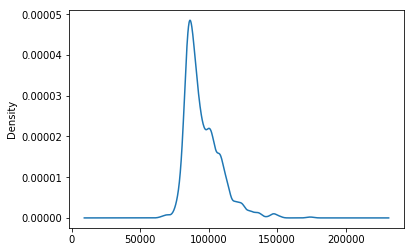

In [8]:
declarations[declarations.decl_count > 2000].money_per_month.plot.density()


In [15]:
declarations.drop_duplicates(['party_name', 'division_id'])

27892

In [16]:
out = declarations.drop_duplicates(['party_name', 'division_id'])[['party_name', 'division_id', 'decl_count', 'money_per_month']]

In [17]:
out.to_json('output/payments_to_doctors.json', force_ascii=False, orient='records')
